In [2]:
from scipy.spatial.distance import cdist, pdist
import pandas as pd
import seaborn as sns
import numpy as np
import os
from matplotlib.pyplot import *

def mmd(X, Y, sigma_sq=None):
    """
    Implements Gretton's test for equality of
    distributions in high-dimensional settings
    using concentration bounds on the maximum
    mean discrepancy (MMD). This function uses
    the unbiased estimator of the MMD (see
    Lemma 6, Gretton et al., 2012) and upper
    bounds the p-value using a Hoeffding
    large-deviation bound (see Theorem 10,
    Gretton et al., 2012).

    The test considers two sets of observed
    datapoints, X and Y, which are assumed to
    be drawn i.i.d. from underlying probability
    distributions P and Q. The null hypothesis
    is that P = Q.

    Note that this function assumes that the number
    of samples from each distribution are equal.

    Reference
    ---------
    Gretton et al. (2012). A Kernel Two-Sample Test.
    Journal of Machine Learning Research 13: 723-773.

    Parameters
    ----------
    X : ndarray (num_samples x num_features)
        First set of observed samples, assumed to be
        drawn from some unknown distribution P.

    Y : ndarray (num_samples x num_features)
        Second set of observed samples, assumed to be
        drawn from some unknown distribution Q.
    
    sigma_sq: float, optional
        Kernel bandwidth parameter. If not provided,
        it is set to the median distance between samples.

    Returns
    -------
    mmd : float
        MMD Distance
    """

    assert X.shape == Y.shape
    m = X.shape[0]

    # Compute pairwise distances
    xd = pdist(X, metric="euclidean")
    yd = pdist(Y, metric="euclidean")
    xyd = cdist(X, Y, metric="euclidean").ravel()
    
    if sigma_sq is None:
        # Set kernel bandwidth (Gretton et al. suggest to use
        # the median distance).
        sigma_sq = np.median(
            np.concatenate((xd, yd, xyd))
        ) ** 2

    # Compute unbiased MMD distance.
    kxx = np.mean(np.exp(-(xd**2) / (2 * sigma_sq)))
    kyy = np.mean(np.exp(-(yd**2) / (2 * sigma_sq)))
    kxy = np.mean(np.exp(-(xyd**2) / (2 * sigma_sq)))
    mmd_obs = kxx + kyy - 2 * kxy

    return mmd_obs

def get_mmd_sigma_sq(X, Y):
    assert X.shape == Y.shape
    m = X.shape[0]
    # Compute pairwise distances
    xd = pdist(X, metric="euclidean")
    yd = pdist(Y, metric="euclidean")
    xyd = cdist(X, Y, metric="euclidean").ravel()

    # Set kernel bandwidth (Gretton et al. suggest to use
    # the median distance).
    sigma_sq = np.median(
        np.concatenate((xd, yd, xyd))
    ) ** 2
    
    return sigma_sq

def permutation_test_mmd(X, Y, n_samples=1000, n_iters=1000):
    
    mmds = []
    for i in range(n_iters):
        #generate random indicies
        x_rand_idx = np.random.choice(np.arange(len(X)), size=n_samples, replace=False)
        y_rand_idx = np.random.choice(np.arange(len(Y)), size=n_samples, replace=False)
        
        #randomly sample data
        x_rand = X[x_rand_idx]
        y_rand = Y[y_rand_idx]    
        
        working_mmd = mmd(x_rand, y_rand, sigma_sq=13.65)
        mmds.append(working_mmd)
    
    return np.array(mmds)

%matplotlib inline

In [3]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')

In [5]:
df = pd.read_feather('vocalization_df.feather')

df_c2 = df[df.cohort=='c2']
df_c4 = df[df.cohort=='c4']
df_c5 = df[df.cohort=='c5']

c2_latents = np.vstack(df_c2.latent_means.values)
c4_latents = np.vstack(df_c4.latent_means.values)
c5_latents = np.vstack(df_c5.latent_means.values)

all_latents = np.concatenate((c2_latents, c4_latents, c5_latents))

In [6]:
shuffle_mmd = permutation_test_mmd(all_latents, all_latents, n_iters = 1000)
c2_c4_mmd = permutation_test_mmd(c2_latents, c4_latents, n_iters = 1000)
c2_c5_mmd = permutation_test_mmd(c2_latents, c5_latents, n_iters = 1000)
c4_c5_mmd = permutation_test_mmd(c4_latents, c5_latents, n_iters = 1000)

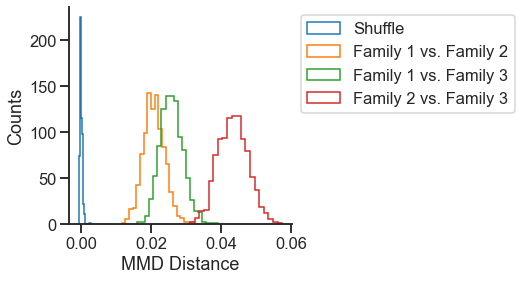

In [7]:
figure(figsize=(4,4))

_bins = 20
hist(shuffle_mmd, histtype='step', bins=_bins, label='Shuffle')

hist(c2_c4_mmd, histtype='step', bins=_bins, label='Family 1 vs. Family 2')
hist(c2_c5_mmd, histtype='step', bins=_bins, label='Family 1 vs. Family 3')
hist(c4_c5_mmd, histtype='step', bins=_bins, label='Family 2 vs. Family 3')
legend(bbox_to_anchor=(1,1))
xlabel('MMD Distance')
ylabel('Counts')
sns.despine();
# savefig('mmd_distance.svg', dpi=300)

In [8]:
from scipy.stats import ttest_ind
print(ttest_ind(shuffle_mmd, c2_c4_mmd, equal_var=False))
print(ttest_ind(shuffle_mmd, c2_c5_mmd, equal_var=False))
print(ttest_ind(shuffle_mmd, c4_c5_mmd, equal_var=False))

Ttest_indResult(statistic=-212.62560321226508, pvalue=0.0)
Ttest_indResult(statistic=-251.6347167517595, pvalue=0.0)
Ttest_indResult(statistic=-321.3126580974118, pvalue=0.0)
